In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pickle import dump
from binance.client import Client

In [2]:
df_1 = yf.download('BTC-USD', start = '2015-01-01', end = '2020-12-31')
df_1 = df_1.drop(['Adj Close'], axis = 1)
df_1

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2014-12-31,310.914001,320.192993,310.210999,320.192993,13942900
2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100
...,...,...,...,...,...
2020-12-26,24677.015625,26718.070312,24522.689453,26437.037109,48332647295
2020-12-27,26439.373047,28288.839844,25922.769531,26272.294922,66479895605
2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594,49056742893


In [3]:
api_key = 'insert api key'
secret_key = 'insert secret key'

In [4]:
client = Client(api_key = api_key, api_secret = secret_key)

In [5]:
# Creating a function to retrieve data based on symbol/pair and desired transactioning interval
# it retrieves all available Binance information 

def get_history(symbol, interval, start = None, end = None):
    
    if start == None:
        start = client._get_earliest_valid_timestamp(symbol=symbol, interval=interval)
    else:
        pass
    bars = client.get_historical_klines(symbol=symbol, interval=interval,
                                       start_str=start, end_str=end, limit = 1000)
    
    df = pd.DataFrame(bars)
    df['Date'] = pd.to_datetime(df.iloc[:,0], unit='ms')
    df.columns = ['Open Time','Open','High','Low','Close','Volume',
                 'Close Time','Quote Asset Volume','Number of Trades',
                 'Taker Buy Base Asset Volume','Taker Buy Quote Asset Volumne',
                 'Ignore','Date']
    
    df = df[['Date','Open','High','Low','Close','Volume']].copy()
    df.set_index('Date', inplace=True)
    
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors = 'coerce')
        
    return df

In [6]:
# Example of generated dataframe using previously defined function

df_2 = get_history('BTCUSDT', '1d', start='2020-12-31')
df_2

,Open,High,Low,Close,Volume
Date,,,,,
2020-12-31,28875.55,29300.00,27850.00,28923.63,75508.505152
2021-01-01,28923.63,29600.00,28624.57,29331.69,54182.925011
2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.873362
2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.566750
2021-01-04,33000.05,33600.00,28130.00,31988.71,140899.885690
...,...,...,...,...,...
2022-05-19,28715.33,30545.18,28691.38,30319.23,67877.364150
2022-05-20,30319.22,30777.33,28730.00,29201.01,60517.253250
2022-05-21,29201.01,29656.18,28947.28,29445.06,20987.131240


In [8]:
df = pd.concat([df_1, df_2], axis=0)
df

,Open,High,Low,Close,Volume
Date,,,,,
2014-12-31,310.914001,320.192993,310.210999,320.192993,1.394290e+07
2015-01-01,320.434998,320.434998,314.002991,314.248993,8.036550e+06
2015-01-02,314.079010,315.838989,313.565002,315.032013,7.860650e+06
2015-01-03,314.846008,315.149994,281.082001,281.082001,3.305440e+07
2015-01-04,281.145996,287.230011,257.612000,264.195007,5.562910e+07
...,...,...,...,...,...
2022-05-19,28715.330000,30545.180000,28691.380000,30319.230000,6.787736e+04
2022-05-20,30319.220000,30777.330000,28730.000000,29201.010000,6.051725e+04
2022-05-21,29201.010000,29656.180000,28947.280000,29445.060000,2.098713e+04


In [10]:
df = df[:-6]

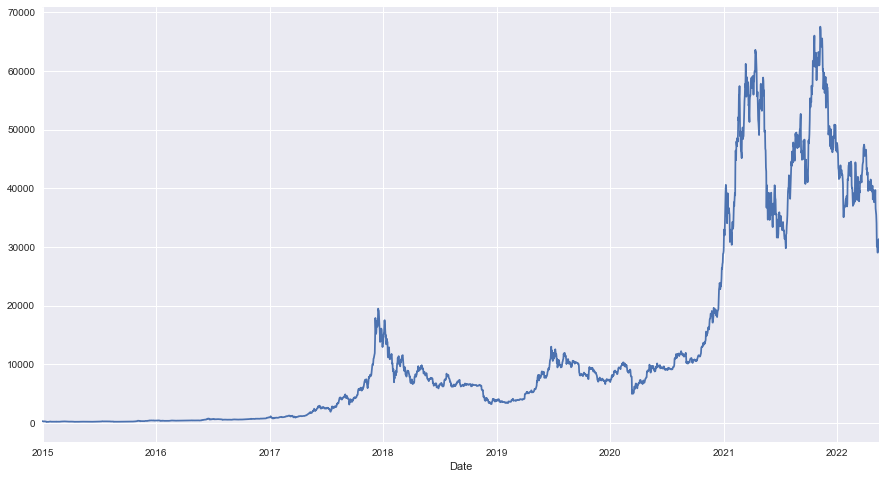

In [39]:
plt.figure(figsize=(15,8))
df['Close'].plot()
plt.show()

In [11]:
test_period = 90 
train_data = pd.DataFrame(df.Close[:len(df) - test_period])
test_data = pd.DataFrame(df.Close[len(df) - test_period:])

In [12]:
df.Close[:len(df) - test_period]

Date
2014-12-31      320.192993
2015-01-01      314.248993
2015-01-02      315.032013
2015-01-03      281.082001
2015-01-04      264.195007
                  ...     
2022-02-12    42217.870000
2022-02-13    42053.660000
2022-02-14    42535.940000
2022-02-15    44544.860000
2022-02-16    43873.560000
Name: Close, Length: 2605, dtype: float64

In [ ]:
df.Close[len(df) - test_period:]

In [ ]:
df[-90:]

In [ ]:
df

In [13]:
first_to_scale = train_data.iloc[0:840,:]
second_to_scale = train_data.iloc[840:2192,:]
third_to_scale = train_data.iloc[2192:,:]

In [ ]:
third_to_scale

In [14]:
# Scaling separately based on trend

scaler = MinMaxScaler()
scaler.fit(first_to_scale)
train_data.iloc[0:840,:] = scaler.transform(first_to_scale)
scaler.fit(second_to_scale)
train_data.iloc[840:2192,:] = scaler.transform(second_to_scale)
scaler.fit(third_to_scale)
train_data.iloc[2192:,:] = scaler.transform(third_to_scale)

In [37]:
# Save scaler to use on future data

# dump(scaler, open('scaler.pkl', 'wb'))

In [15]:
test_data = scaler.transform(test_data)

In [16]:
train_data = train_data.values.reshape(-1,1)
train_data

array([[0.12953932],
       [0.12412035],
       [0.12483421],
       ...,
       [0.35263042],
       [0.40467201],
       [0.38728181]])

In [17]:
trainX = []
trainY = []

n_future = 1 #Numarul de zile pe care vrem sa-l prezicem in viitor
n_past = 12 #Numarul de zile pe care il folosim pentru predictie

#print(DatasetTrainingScaled.shape)

for i in range(n_past, len(train_data)-n_future+1):
    trainX.append(train_data[i - n_past:i, 0:train_data.shape[1]])
    trainY.append(train_data[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print(type(trainX))

trainX shape == (2593, 12, 1).
trainY shape == (2593, 1).
<class 'numpy.ndarray'>


In [18]:
# define model

model = Sequential()
model.add(LSTM(200, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation = 'tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(100, activation = 'tanh', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 200)           161600    
_________________________________________________________________
dropout (Dropout)            (None, 12, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 150)           210600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 150)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [20]:
model.fit(trainX, trainY,epochs=50, batch_size=25)

Epoch 1/50
104/104 [==============================] - 3s 24ms/step - loss: 0.0111
Epoch 2/50
104/104 [==============================] - 3s 27ms/step - loss: 0.0060
Epoch 3/50
104/104 [==============================] - 3s 25ms/step - loss: 0.0055
Epoch 4/50
104/104 [==============================] - 3s 27ms/step - loss: 0.0042
Epoch 5/50
104/104 [==============================] - 3s 29ms/step - loss: 0.0041
Epoch 6/50
104/104 [==============================] - 3s 27ms/step - loss: 0.0035
Epoch 7/50
104/104 [==============================] - 3s 27ms/step - loss: 0.0030
Epoch 8/50
104/104 [==============================] - 3s 27ms/step - loss: 0.0028
Epoch 9/50
104/104 [==============================] - 3s 27ms/step - loss: 0.0026
Epoch 10/50
104/104 [==============================] - 3s 27ms/step - loss: 0.0024
Epoch 11/50
104/104 [==============================] - 3s 27ms/step - loss: 0.0029
Epoch 12/50
104/104 [==============================] - 3s 27ms/step - loss: 0.0024
Epoch 13/50
1

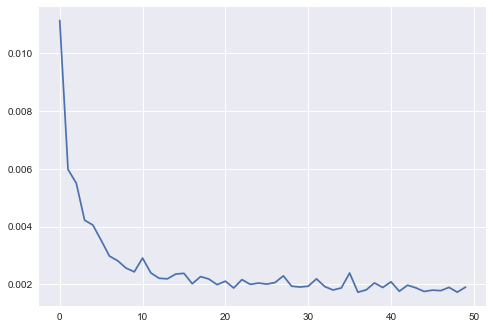

In [21]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
# train_data_reorg = []
# test_data_reorg = []

# for i in range(len(train_data)):
#     train_data_reorg.append(train_data[i].item())

# for i in range(len(test_data)):
#     test_data_reorg.append(test_data[i].item())

In [ ]:
# inputs = pd.concat((pd.Series(train_data_reorg), pd.Series(test_data_reorg)), axis=0)
# inputs = inputs[len(inputs) - len(test_data_reorg)-12:]

In [1]:
inputs = np.concatenate((train_data, test_data), axis=0)
inputs = inputs[len(inputs) - len(test_data)-12:]

NameError: name 'np' is not defined

In [23]:
x_test = []
for i in range (n_past, len(inputs) - n_future + 1):
    x_test.append(inputs[i-n_past:i])

x_test = np.array(x_test)
print(x_test)

[[[0.32275259]
  [0.34861329]
  [0.38641217]
  ...
  [0.35263042]
  [0.40467201]
  [0.38728181]]

 [[0.34861329]
  [0.38641217]
  [0.39167094]
  ...
  [0.40467201]
  [0.38728181]
  [0.30029558]]

 [[0.38641217]
  [0.39167094]
  [0.40021268]
  ...
  [0.38728181]
  [0.30029558]
  [0.2862741 ]]

 ...

 [[0.2281041 ]
  [0.27890561]
  [0.19764003]
  ...
  [0.00274907]
  [0.00941449]
  [0.03013067]]

 [[0.27890561]
  [0.19764003]
  [0.18367192]
  ...
  [0.00941449]
  [0.03013067]
  [0.06230888]]

 [[0.19764003]
  [0.18367192]
  [0.16964733]
  ...
  [0.03013067]
  [0.06230888]
  [0.02461984]]]


In [24]:
predicted_price = model.predict(x_test)

In [25]:
predicted_price_usd = scaler.inverse_transform(predicted_price)

In [26]:
true = scaler.inverse_transform(test_data)

In [27]:
predictions = []
true_values = []

for i in range(len(true)):
    predictions.append(predicted_price_usd[i].item())
    true_values.append(true[i].item())

In [28]:
diff = pd.DataFrame({'true': true_values, 'pred':predictions})
diff

,true,pred
0,40515.70,43927.960938
1,39974.44,40962.304688
2,40079.17,40240.824219
3,38386.89,40159.062500
4,37008.16,38637.089844
...,...,...
85,29287.05,28920.400391
86,30086.74,29120.570312
87,31328.89,29921.617188
88,29874.01,31190.279297


<AxesSubplot:>

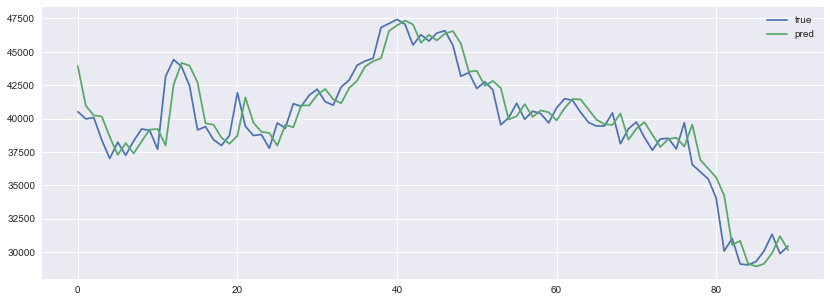

In [29]:
diff.plot(figsize=(14,5))

In [38]:
# save model for later use

# model.save('bitcoin_model.h5')

In [30]:
rmse = np.sqrt(mean_squared_error(diff['true'],diff['pred']))
print(rmse)

1435.1806942000364


In [31]:
mae = mean_absolute_error(diff['true'],diff['pred'])
print(mae)

1073.8975503472222


In [34]:
performance = model.predict(inputs[-12:].reshape(1,12,1))

In [35]:
scaler.inverse_transform(performance)

array([[30514.14]], dtype=float32)